In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ast import literal_eval as lv
from data import PathPlanningCSVOperator
from PIL import Image

In [2]:
with open('config/config.json', 'r') as f:
    cfg = json.load(f)

# FMT*

In [3]:
ALG = 'fmt'
MAPS = {
    2: "Alternating Gaps",
    10: "Bugtrap Forest",
    13: "Forest",
    19: "Gaps Forest",
    24: "Maze",
    28: "Multi Bug Trap",
    37: "Bug Trap"
}
MODE = 'evaluation'
HW = cfg["fmt"]["heuristic_weights"] # FMT* specific (DONT CHANGE!)

In [4]:
dlist = []
for hw in HW:
    CSVOperator = PathPlanningCSVOperator(ALG, MODE, f'_hw_{hw}')
    df = pd.read_csv(CSVOperator.fpath)
    df["Any Path Found"] = df["Any Path Found"].astype('int')
    dlist.append(df)

# BIT*

In [5]:
bitdf = pd.read_csv('bit_star/results/evaluation_data/test.csv')
bitdf["Start Point"] = [str(list(reversed(lv(bitdf["Start Point"][i])))) for i in range(len(bitdf))]
bitdf["Goal Point"] = [str(list(reversed(lv(bitdf["Goal Point"][i])))) for i in range(len(bitdf))]
bitdf["Any Path Found"] = bitdf["Any Path Found"].astype('int')

# NRRT*

> **_TODO_**

> **_NOTE:_**  Add grid-plot showing the maps used

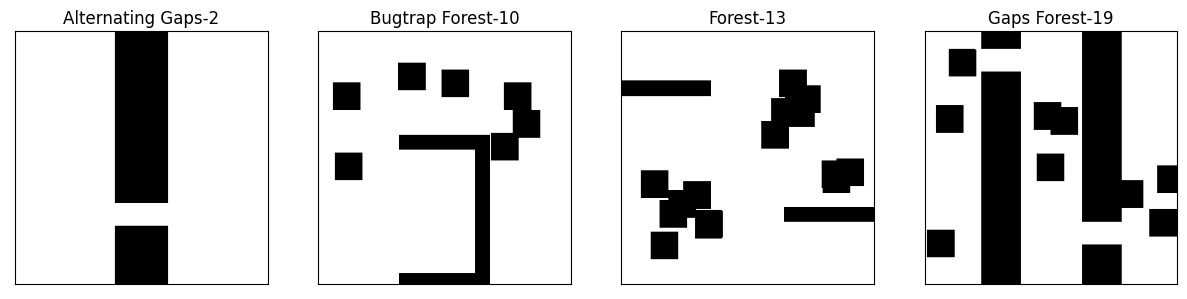

In [6]:
f1, ax1 = plt.subplots(1, 4, figsize=(15,15))

# Maps
for i in range(4):
    map_path = cfg['maps'][f'map{cfg["map_idxs"][i]-1}']["path"]
    # read the image
    im = Image.open(map_path)
    # show image
    ax1[i].imshow(im, cmap='gray')
    ax1[i].set_xticks([])
    ax1[i].set_yticks([])
    ax1[i].set_title(f"{MAPS[cfg['map_idxs'][i]]}-{cfg['map_idxs'][i]}")

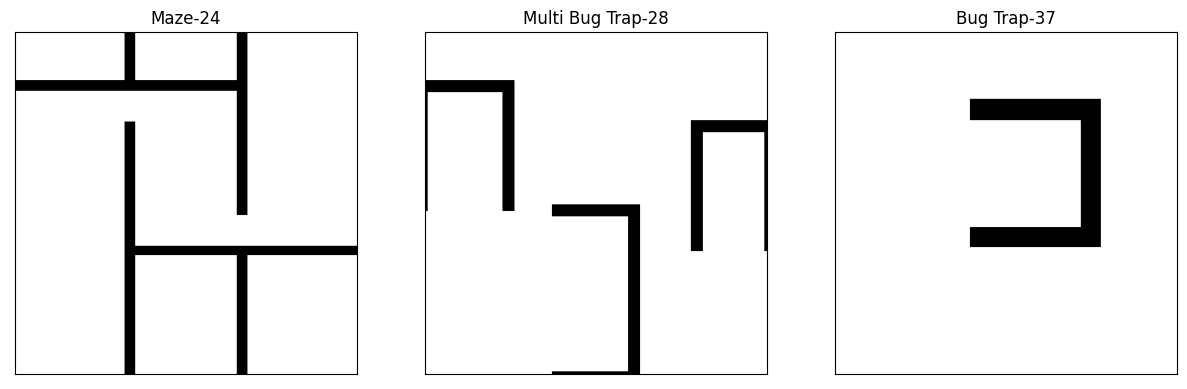

In [7]:
f2, ax2 = plt.subplots(1, 3, figsize=(15,15))
# Maps
for i in range(3):
    map_path = cfg['maps'][f'map{cfg["map_idxs"][i+4]-1}']["path"]
    # read the image
    im = Image.open(map_path)
    # show image
    ax2[i].imshow(im, cmap='gray')
    ax2[i].set_xticks([])
    ax2[i].set_yticks([])
    ax2[i].set_title(f"{MAPS[cfg['map_idxs'][i+4]]}-{cfg['map_idxs'][i+4]}")

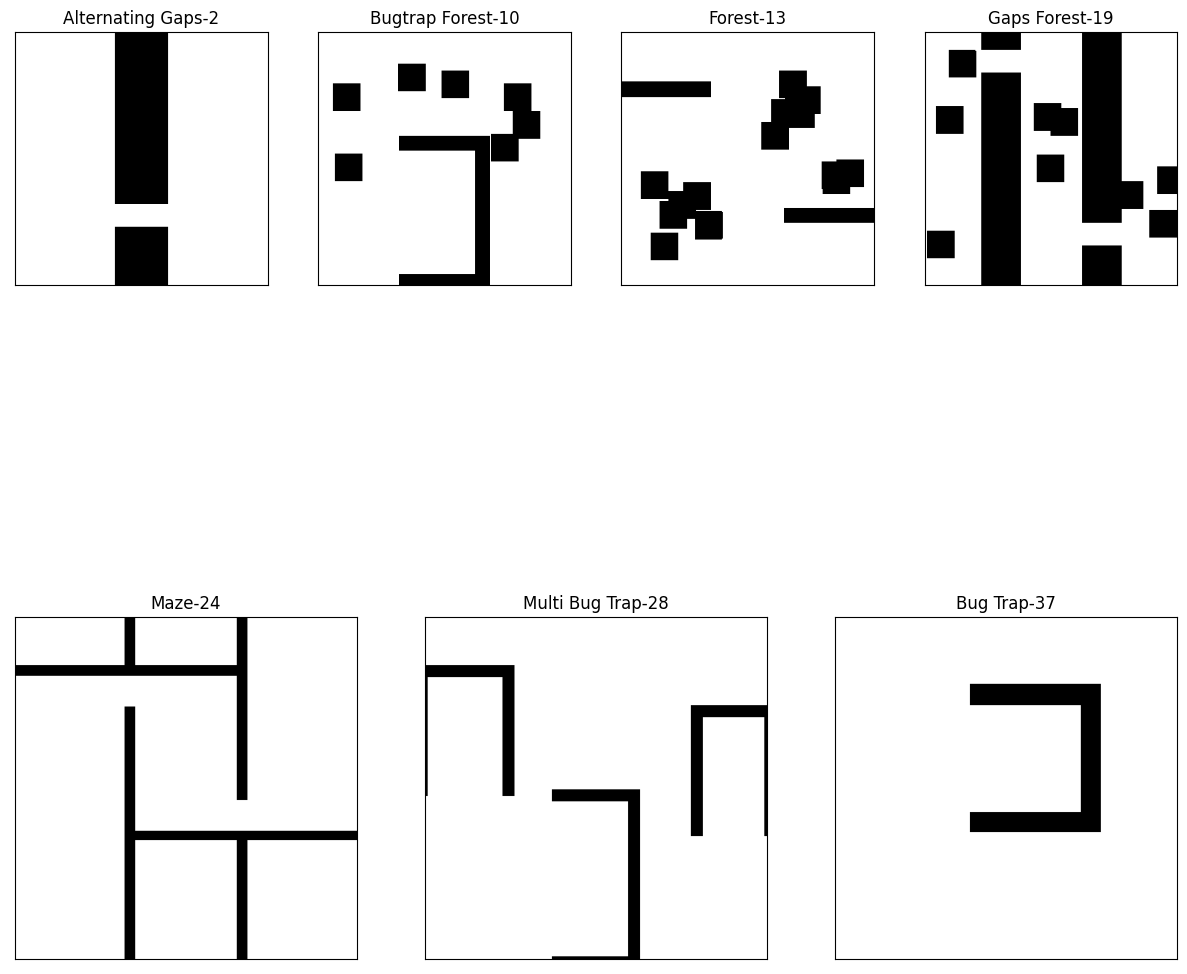

In [8]:
f = plt.figure(figsize=(15,15))
f.add_subplot(2,4,1)
f.add_subplot(2,4,2)
f.add_subplot(2,4,3)
f.add_subplot(2,4,4)
f.add_subplot(2,3,4)
f.add_subplot(2,3,5)
f.add_subplot(2,3,6)

# Maps
for i in range(7):
    map_path = cfg['maps'][f'map{cfg["map_idxs"][i]-1}']["path"]
    # read the image
    im = Image.open(map_path)
    # show image
    f.axes[i].imshow(im, cmap='gray')
    f.axes[i].set_xticks([])
    f.axes[i].set_yticks([])
    f.axes[i].set_title(f"{MAPS[cfg['map_idxs'][i]]}-{cfg['map_idxs'][i]}")

f.savefig('results/MapsGridPlot.png',bbox_inches='tight')

## Solution Cost vs Execution Time

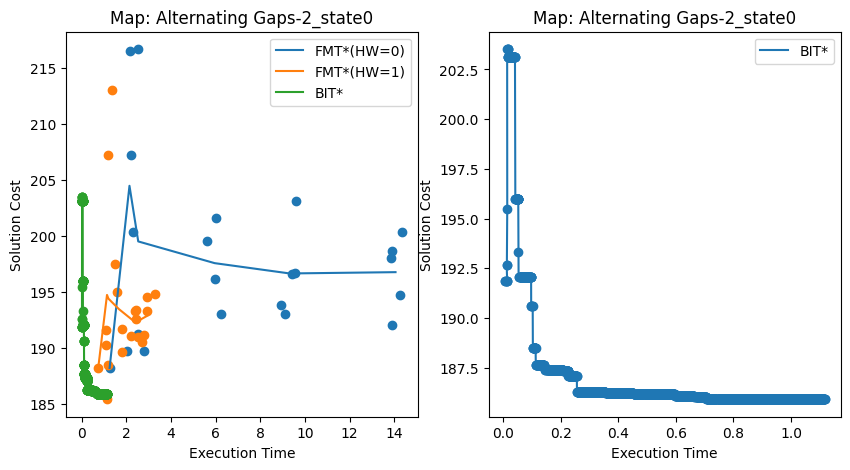

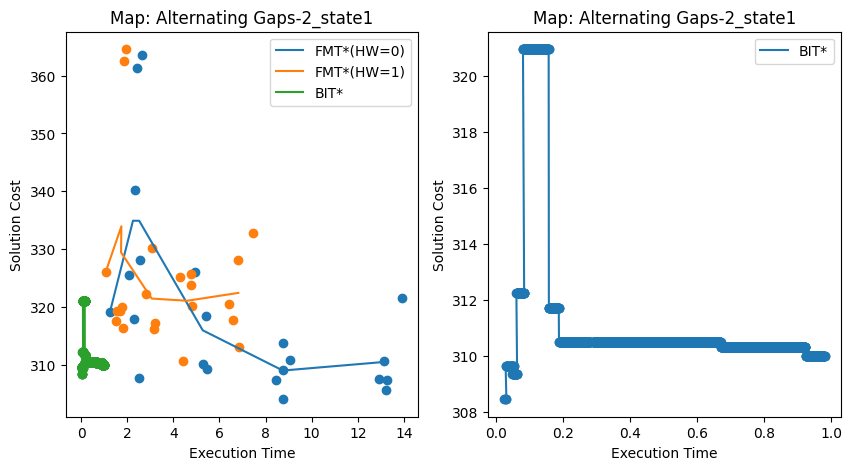

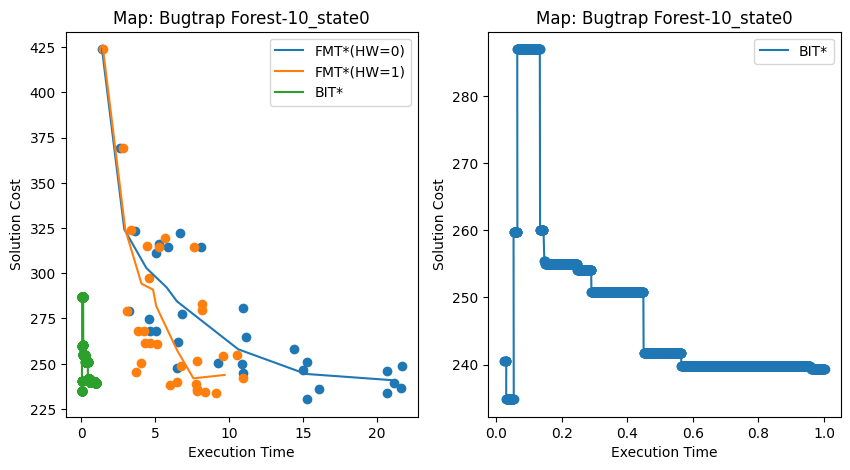

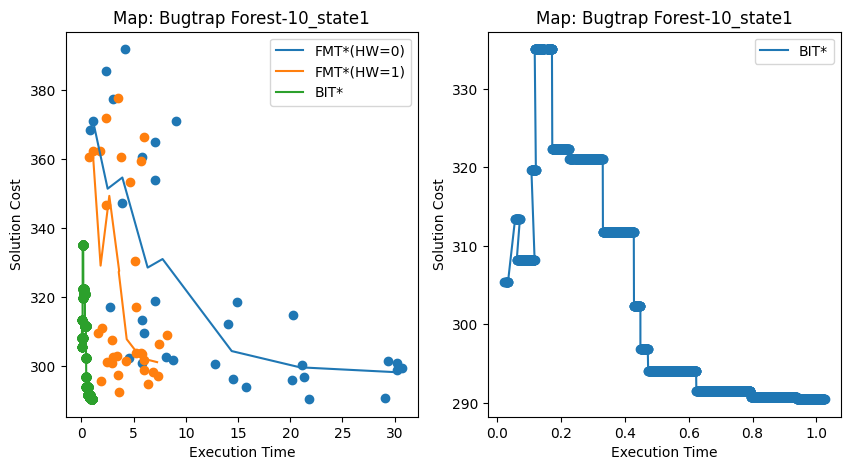

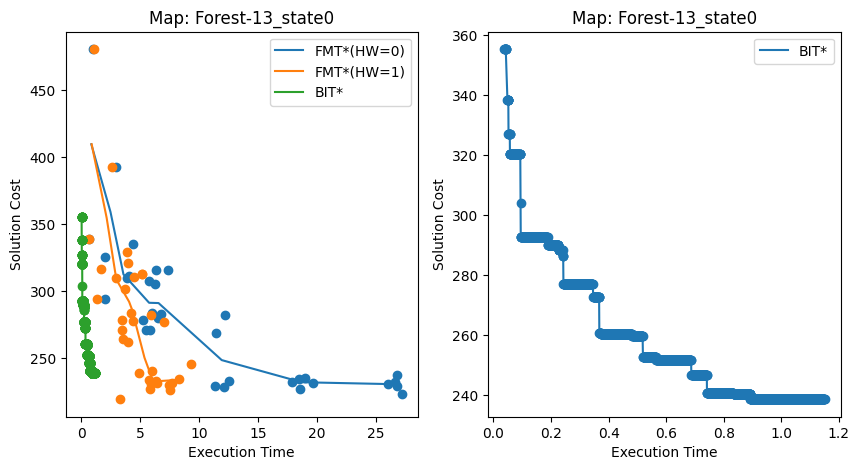

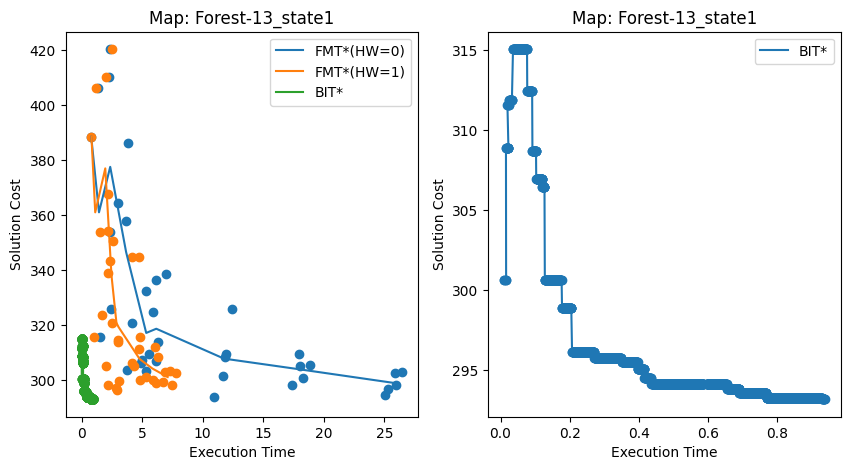

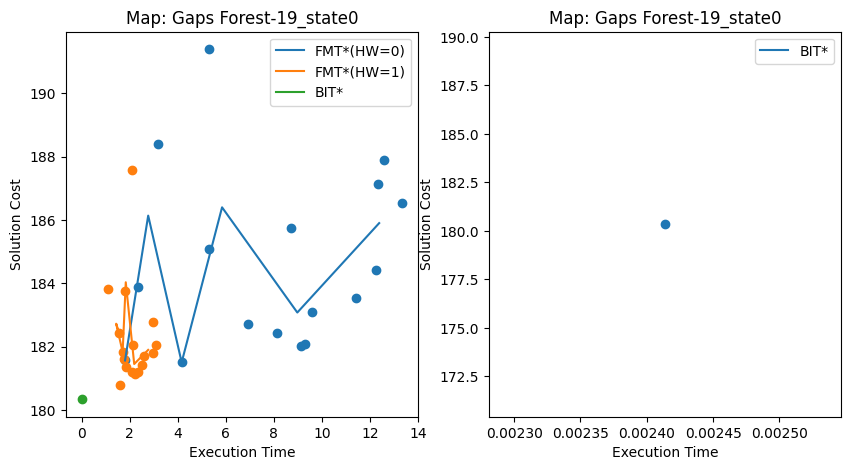

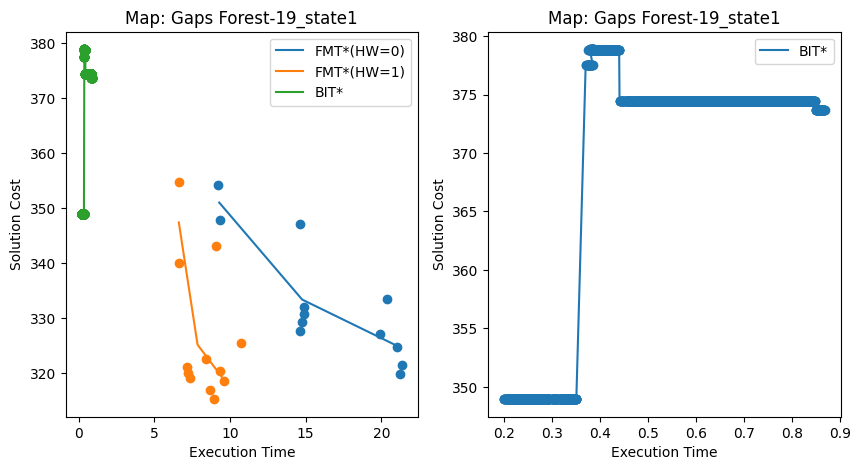

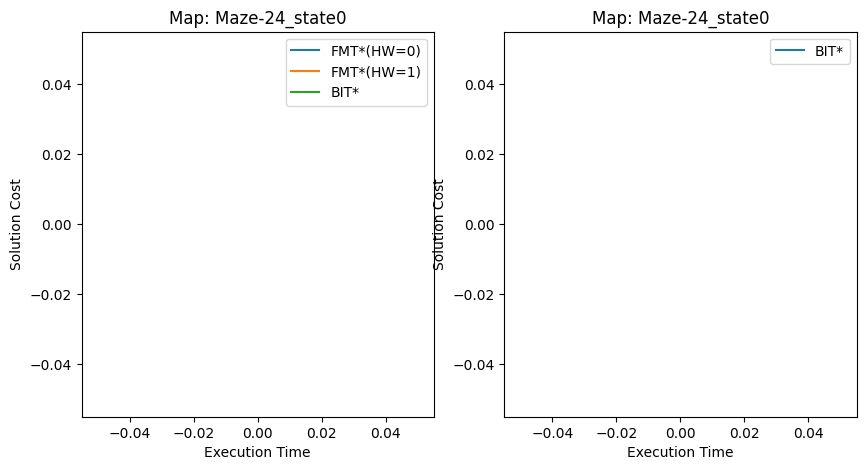

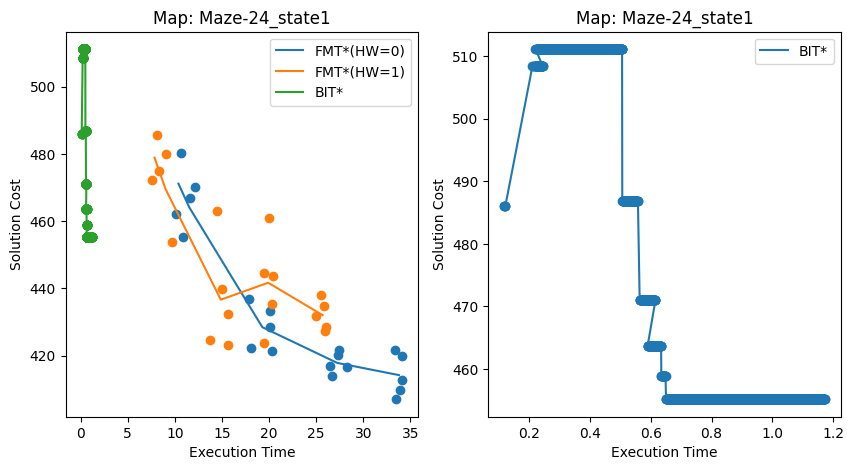

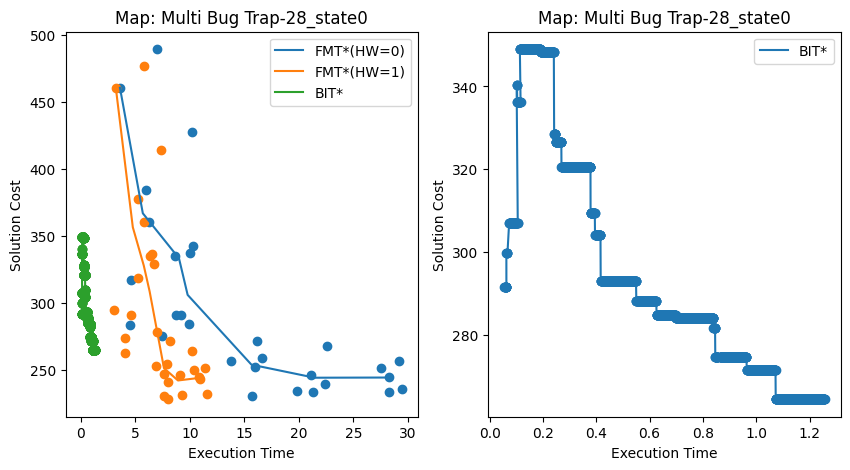

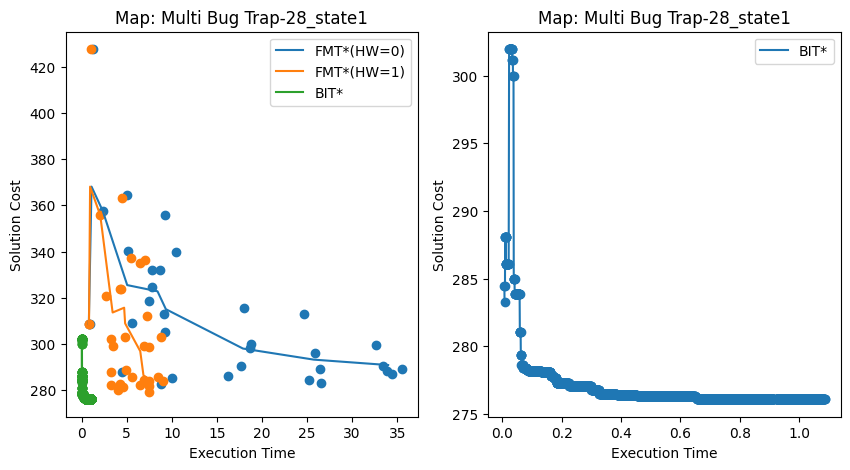

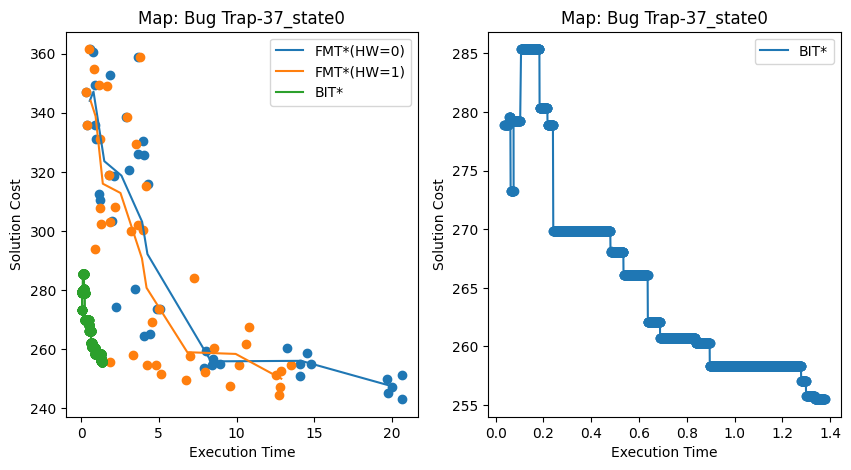

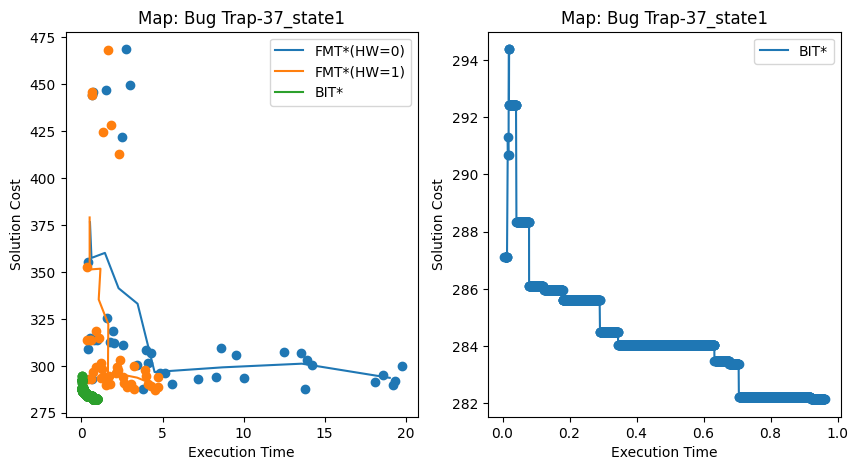

In [9]:
for idx in dlist[0]["Map Id"].unique():
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].set_xlabel("Execution Time")
        ax[0].set_ylabel("Solution Cost")
        ax[0].set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        ax[1].set_xlabel("Execution Time")
        ax[1].set_ylabel("Solution Cost")
        ax[1].set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        # FMT*
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp) & (ddf["Any Path Found"])]
            scatterdf = mapi_data[["Timestep", "Current Path Cost"]]
            linedf = mapi_data[["Timestep", "Current Path Cost", "Batch Size"]].groupby(["Batch Size"]).mean()

            ax[0].scatter(scatterdf["Timestep"], scatterdf["Current Path Cost"])
            ax[0].plot(linedf["Timestep"], linedf["Current Path Cost"], label=f"FMT*(HW={HW[i]})")
        # BIT*
        for i in range(2):
            mapi_data = bitdf[(bitdf["Map Id"] == idx) & (bitdf["Start Point"] == sp) & (bitdf["Any Path Found"])]
            plotdf = mapi_data[["Timestep", "Current Path Cost", "Iteration"]].groupby("Iteration").mean()
            ax[i].scatter(plotdf["Timestep"], plotdf["Current Path Cost"])
            ax[i].plot(plotdf["Timestep"], plotdf["Current Path Cost"], label="BIT*")
            ax[i].legend(loc='upper right')
        # Save plot
        fig.savefig(f"results/scVet_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")

# Success Rate vs Execution Time

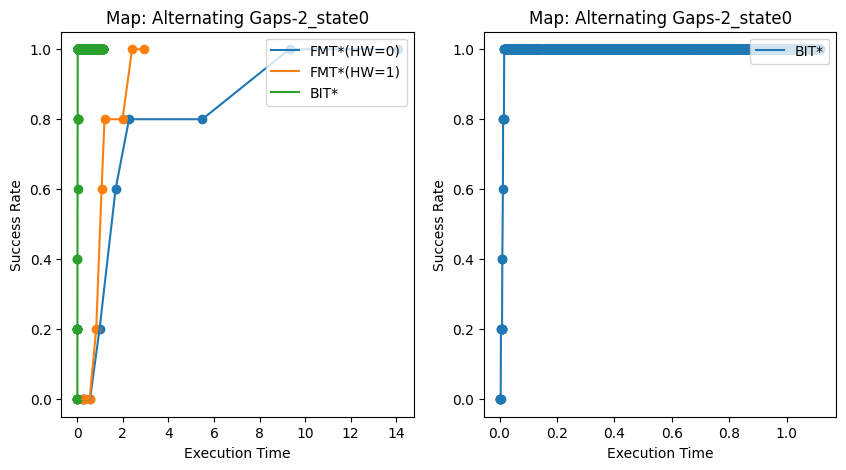

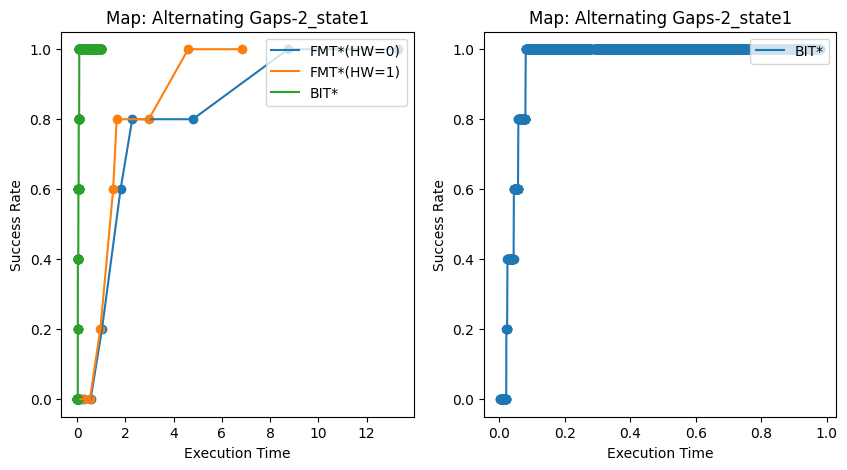

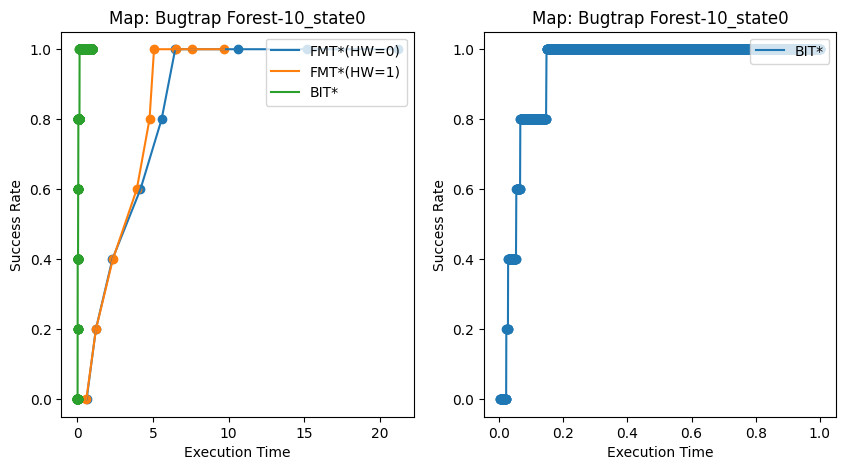

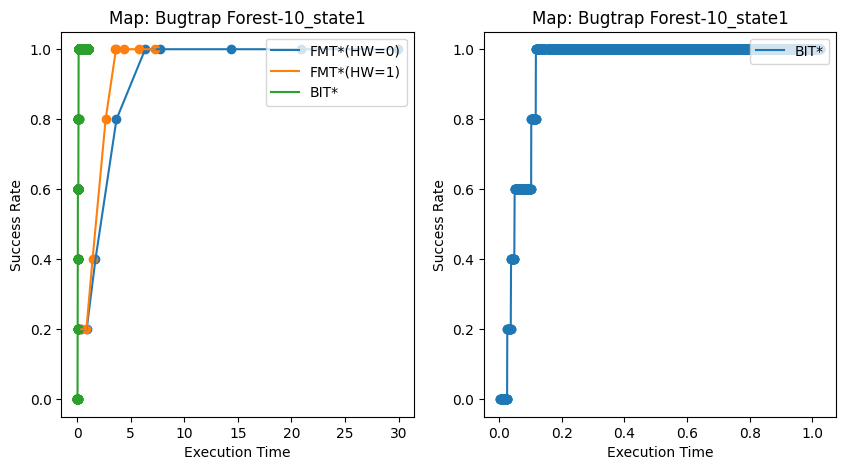

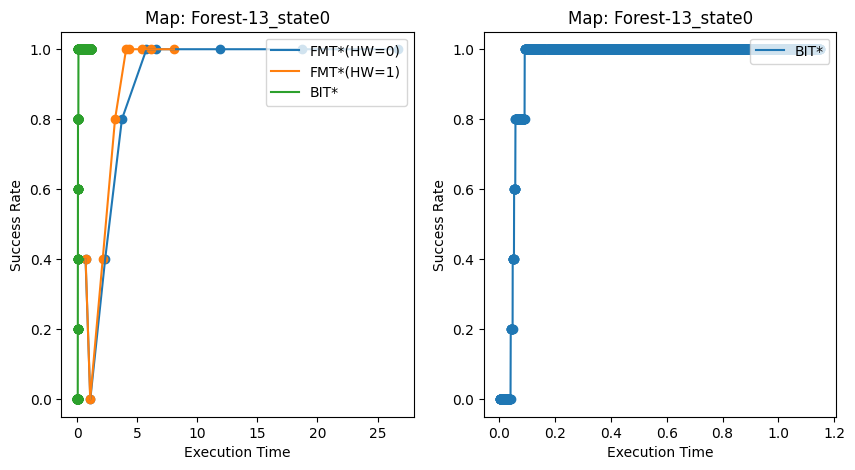

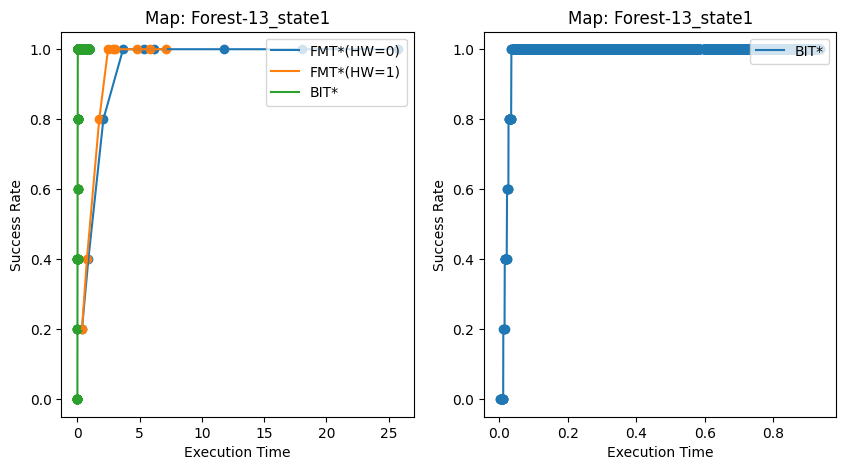

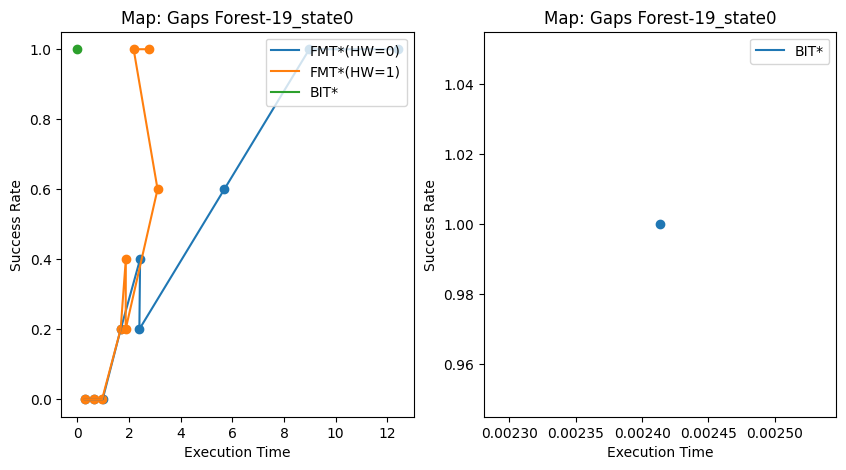

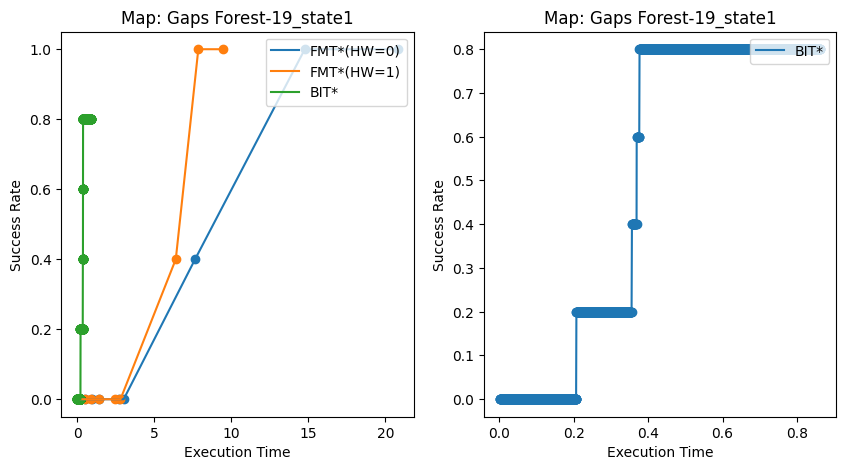

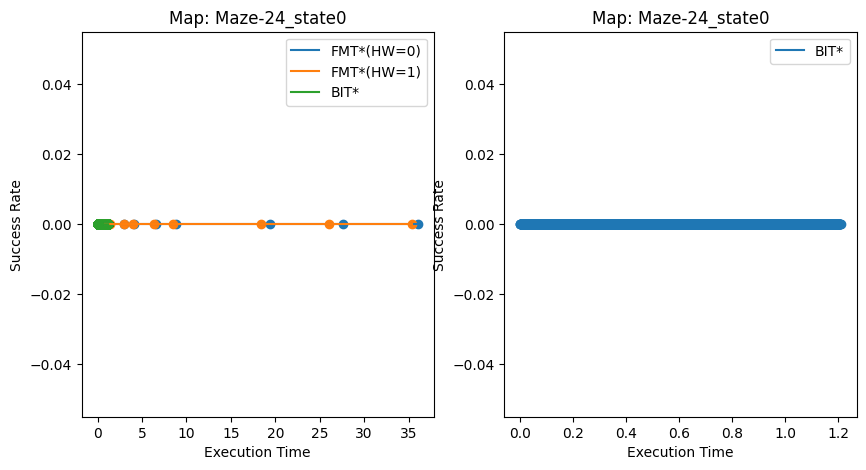

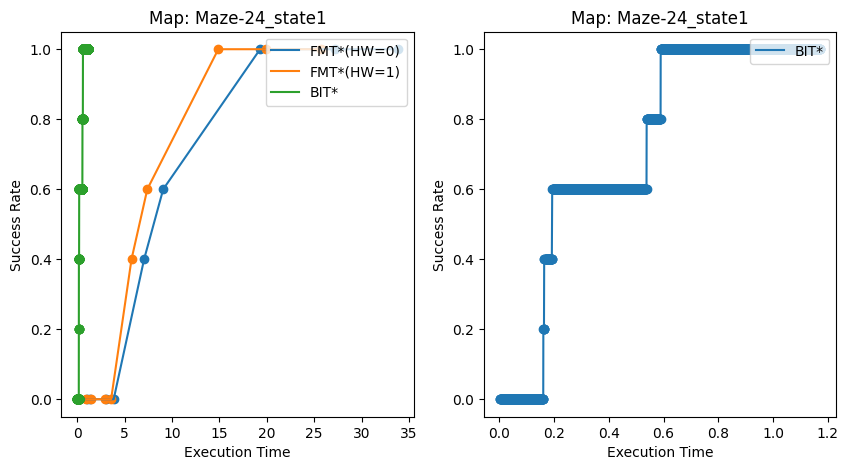

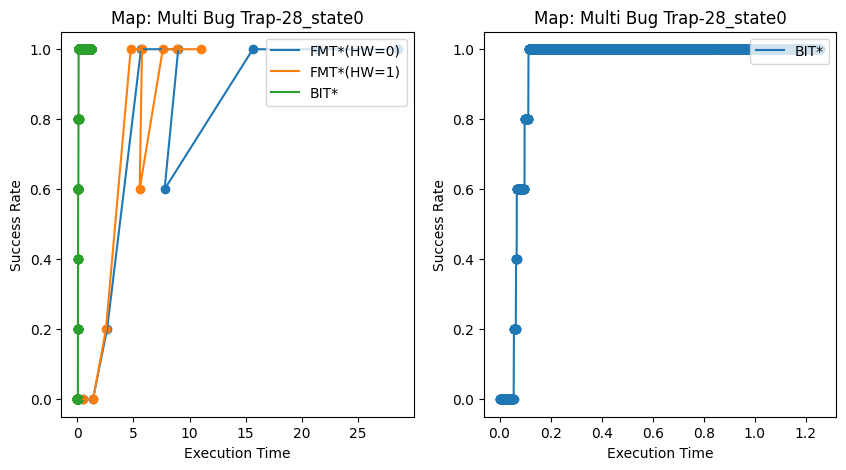

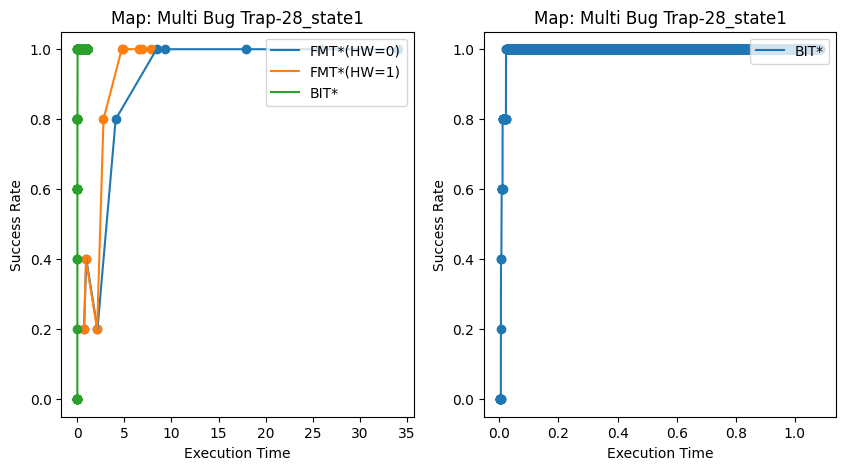

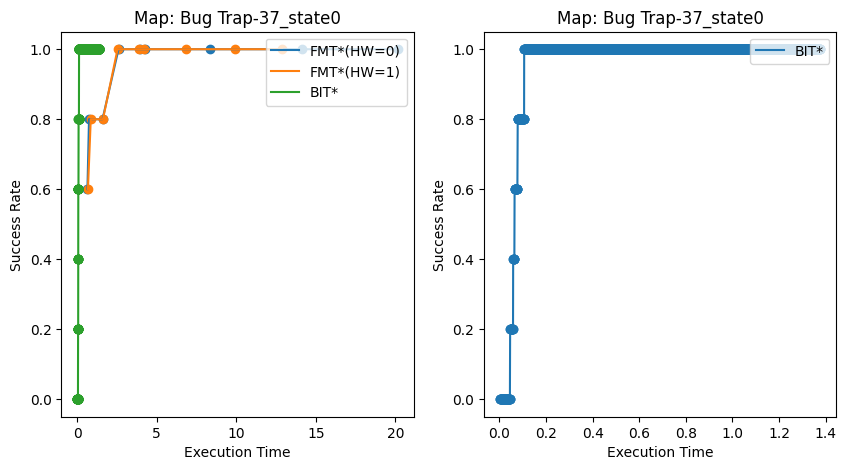

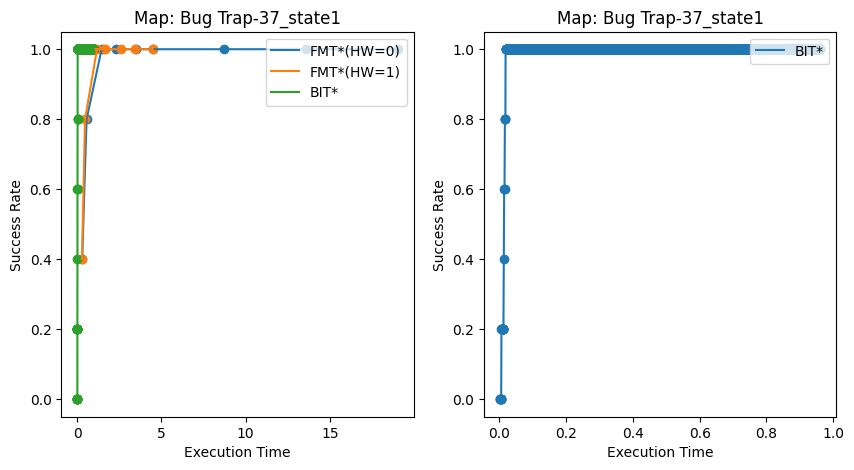

In [10]:
for idx in dlist[0]["Map Id"].unique():
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].set_xlabel("Execution Time")
        ax[0].set_ylabel("Success Rate")
        ax[0].set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        ax[1].set_xlabel("Execution Time")
        ax[1].set_ylabel("Success Rate")
        ax[1].set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        # FMT*
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp)]
            plotdf = pd.concat([
                        mapi_data[["Timestep", "Batch Size"]].groupby(["Batch Size"]).mean(),
                        mapi_data[["Any Path Found", "Batch Size"]].groupby(["Batch Size"]).sum()/cfg["runs_per_map"]
                    ], axis=1)

            ax[0].scatter(plotdf["Timestep"], plotdf["Any Path Found"])
            ax[0].plot(plotdf["Timestep"], plotdf["Any Path Found"], label=f"FMT*(HW={HW[i]})")
        # BIT*
        for i in range(2):
            mapi_data = bitdf[(bitdf["Map Id"] == idx) & (bitdf["Start Point"] == sp)]
            plotdf = pd.concat([
                            mapi_data[["Timestep", "Iteration"]].groupby(["Iteration"]).mean(),
                            mapi_data[["Any Path Found", "Iteration"]].groupby(["Iteration"]).sum()/cfg["runs_per_map"]
                        ], axis=1)
            ax[i].scatter(plotdf["Timestep"], plotdf["Any Path Found"])
            ax[i].plot(plotdf["Timestep"], plotdf["Any Path Found"], label="BIT*")
            ax[i].legend(loc='upper right')
        # Save plot
        fig.savefig(f"results/srVet_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")

# Sample Count vs Collision Check

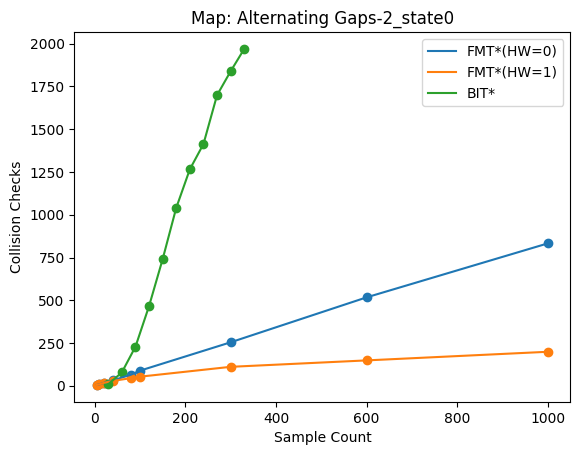

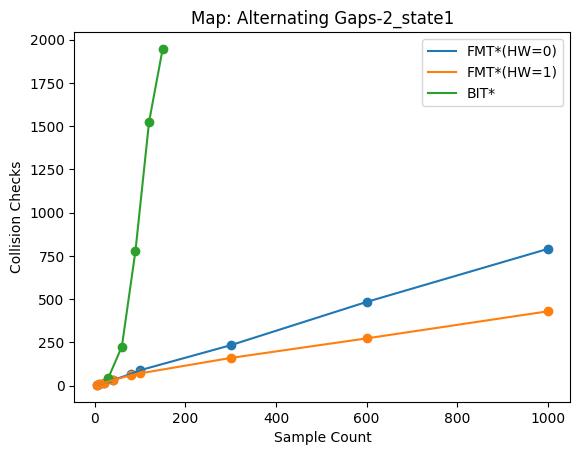

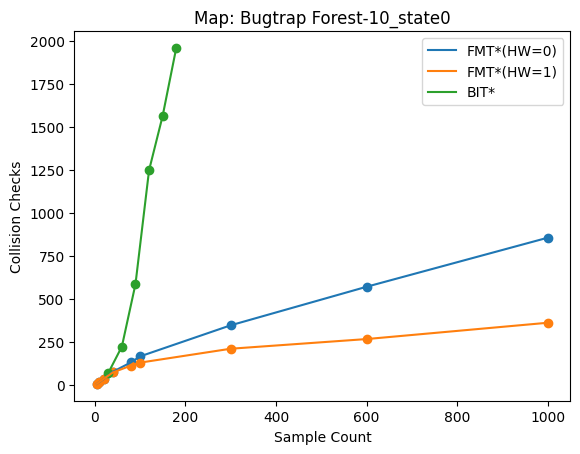

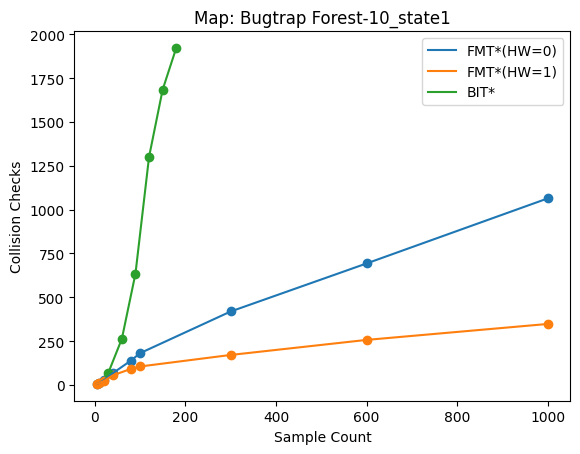

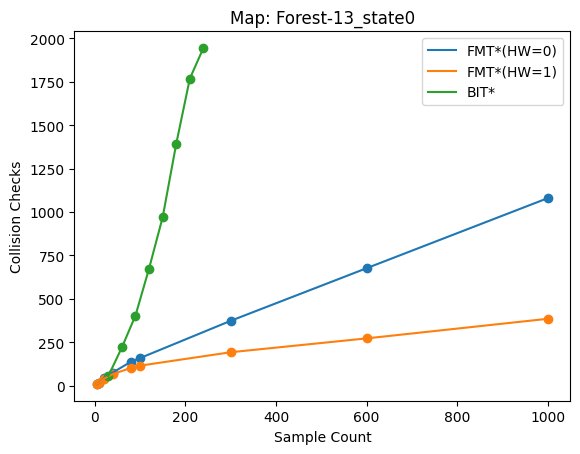

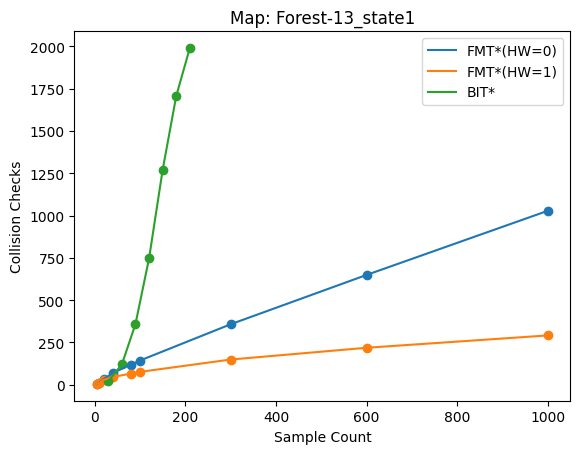

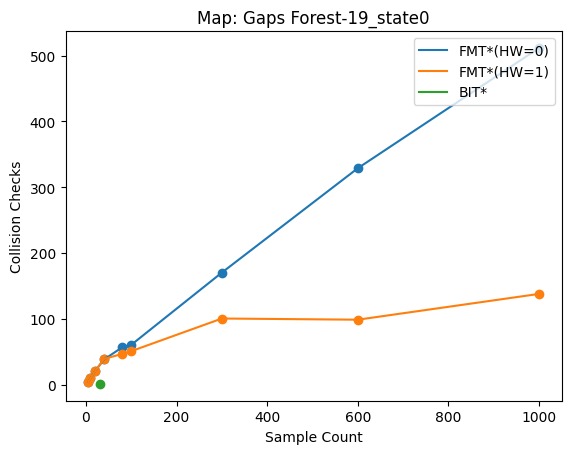

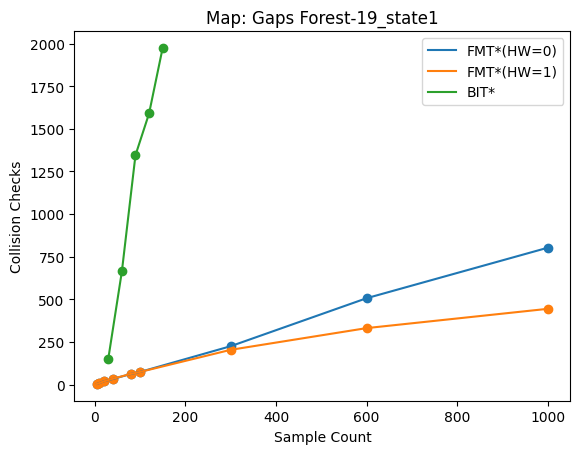

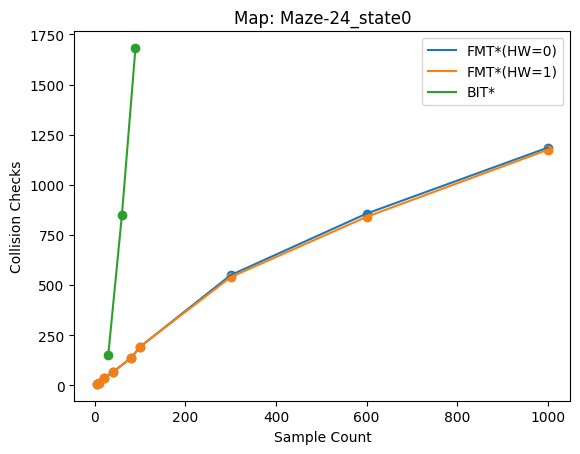

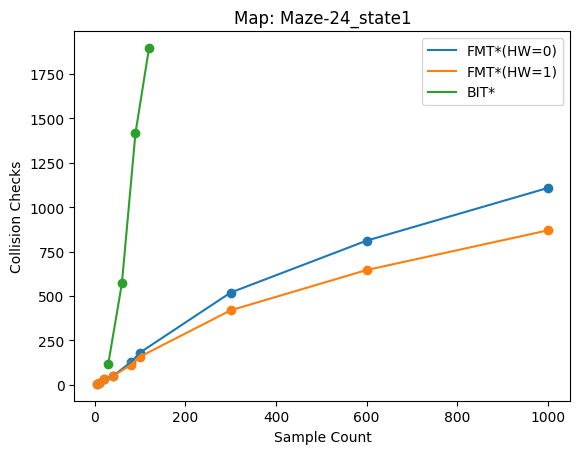

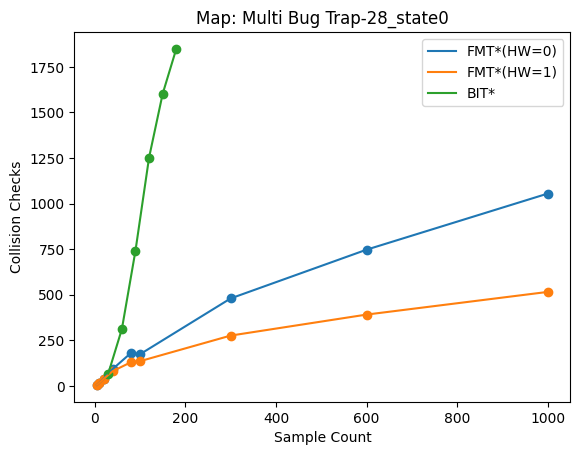

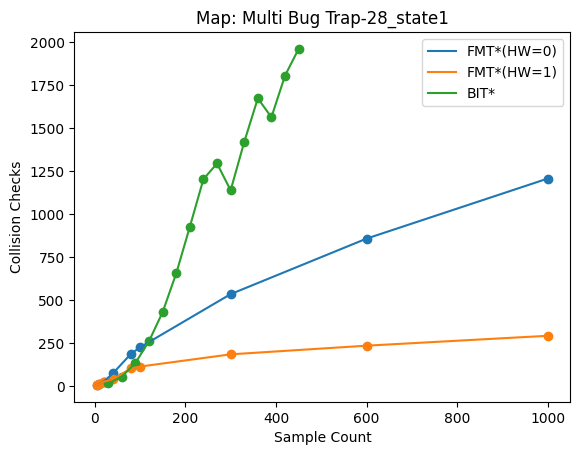

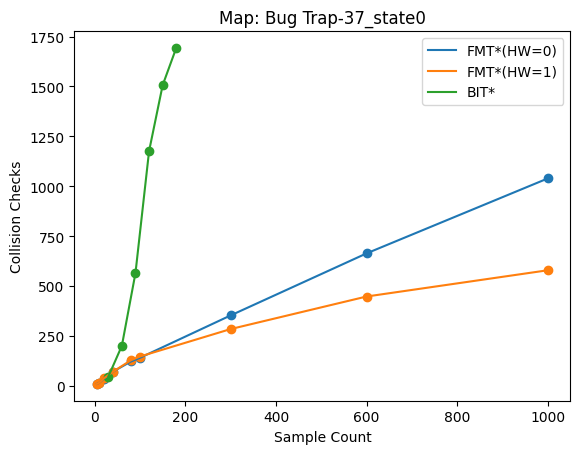

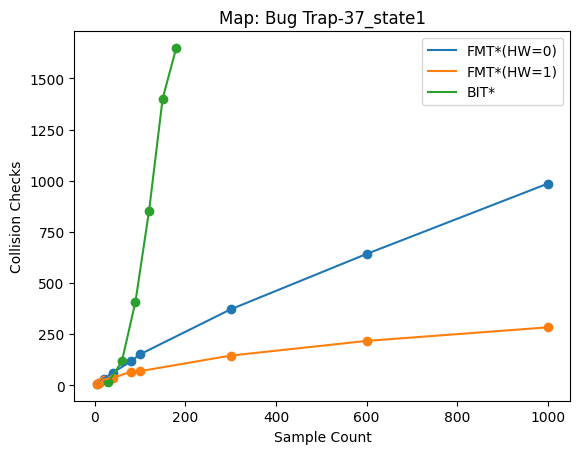

In [11]:
for idx in dlist[0]["Map Id"].unique():
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots()
        ax.set_xlabel("Sample Count")
        ax.set_ylabel("Collision Checks")
        ax.set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        # FMT*
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp)]
            plotdf = mapi_data[["Batch Size", "Num Collision Checks"]].groupby("Batch Size").mean().reset_index()

            ax.scatter(plotdf["Batch Size"], plotdf["Num Collision Checks"])
            ax.plot(plotdf["Batch Size"], plotdf["Num Collision Checks"], label=f"FMT*(HW={HW[i]})")
        # BIT*
        mapi_data = bitdf[(bitdf["Map Id"] == idx) & (bitdf["Start Point"] == sp)]
        plotdf = mapi_data[["Cumulative Num Sampled", "Num Collision Checks"]].groupby("Cumulative Num Sampled").mean().reset_index()
        ax.scatter(plotdf["Cumulative Num Sampled"], plotdf["Num Collision Checks"])
        ax.plot(plotdf["Cumulative Num Sampled"], plotdf["Num Collision Checks"], label="BIT*")        
        ax.legend(loc='upper right')
        # Save plot
        fig.savefig(f"results/scVcc_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")

# Success Rate vs Sample count

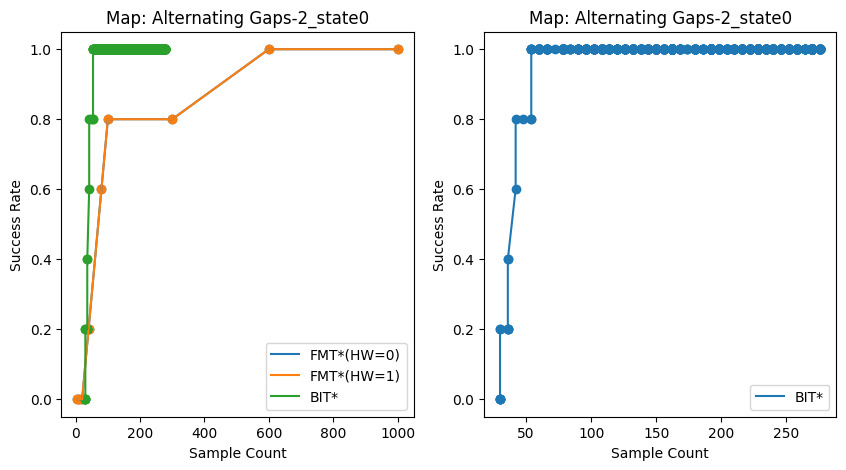

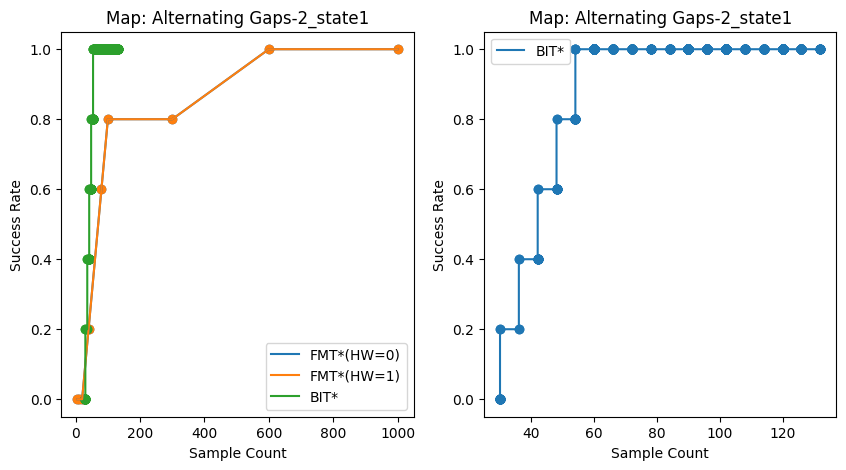

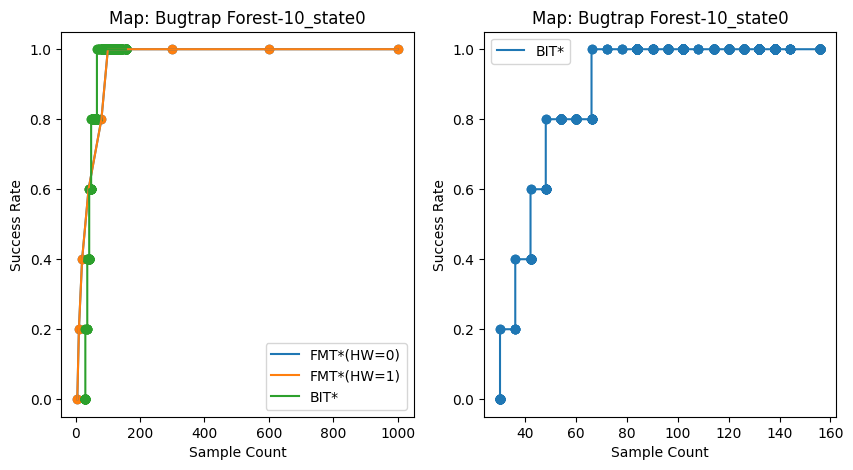

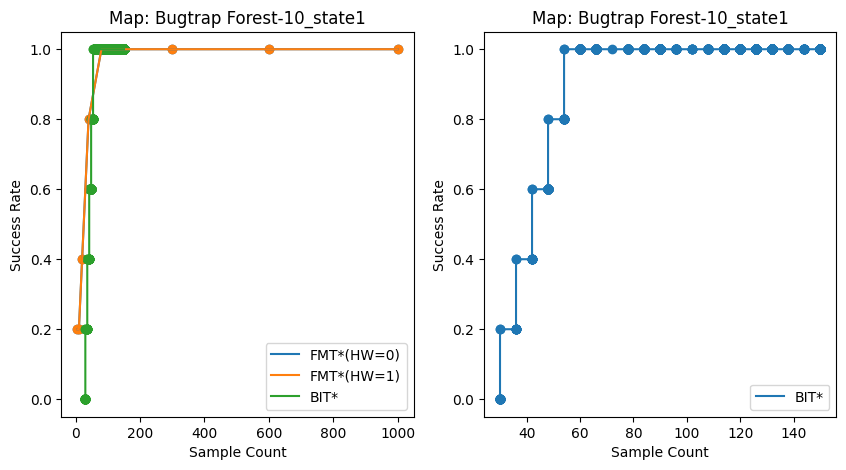

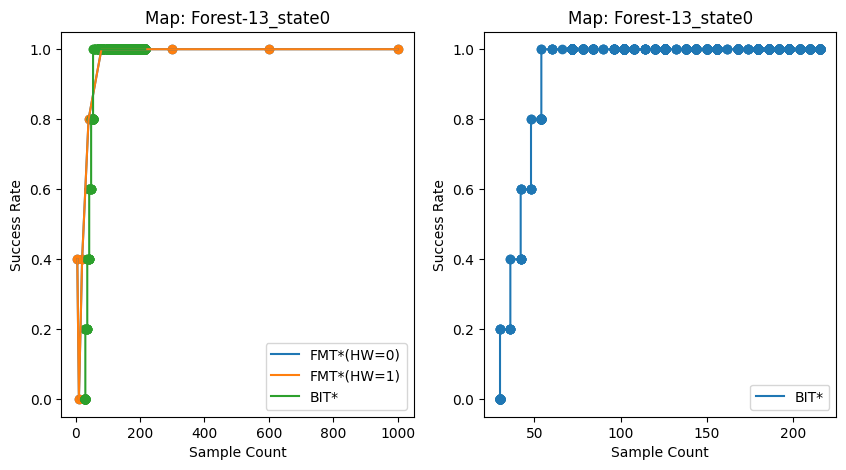

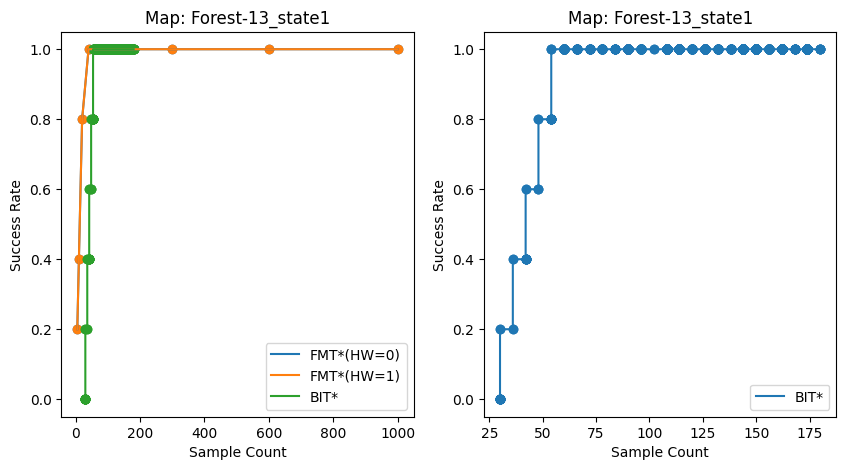

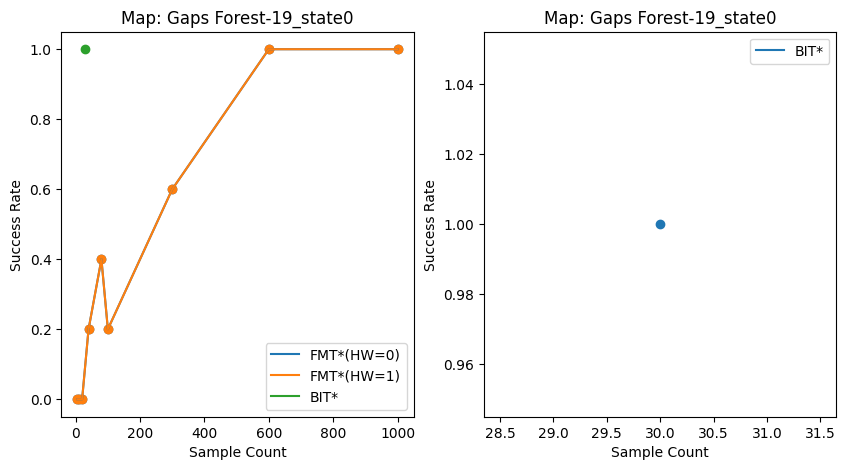

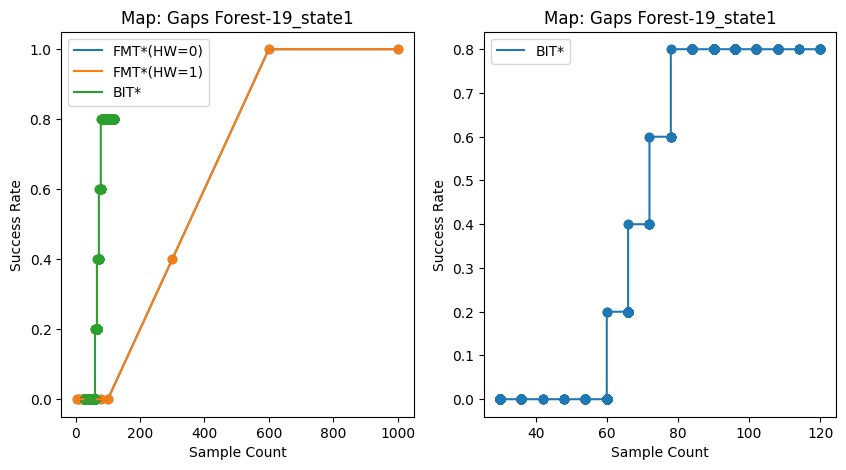

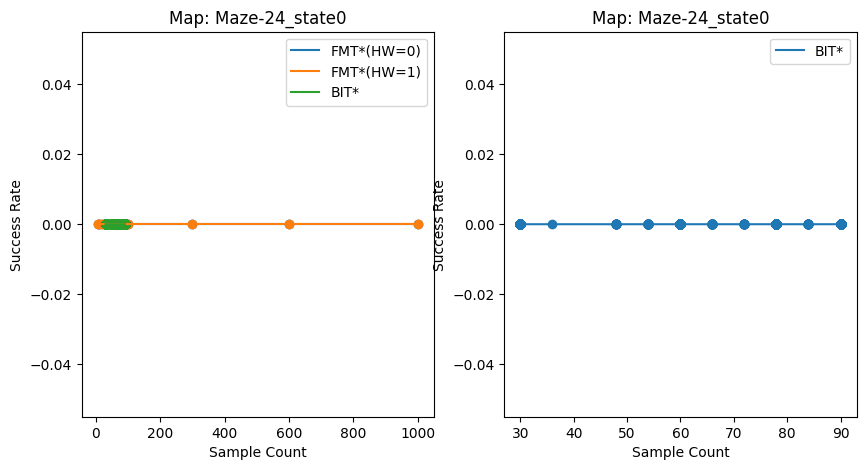

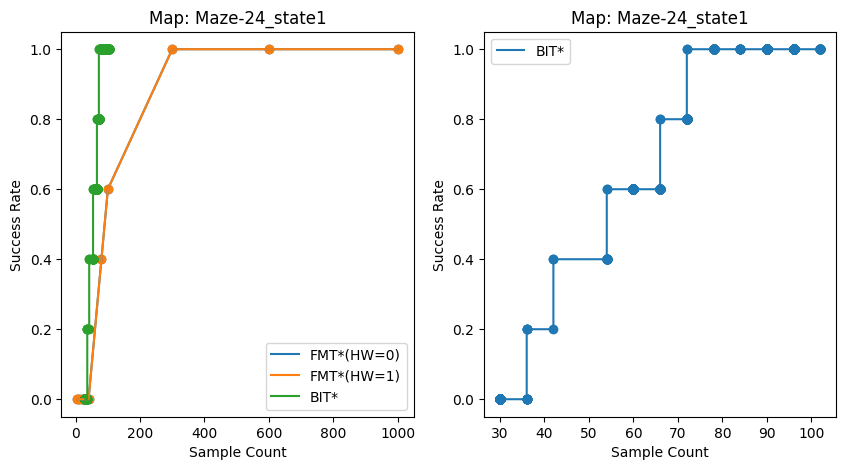

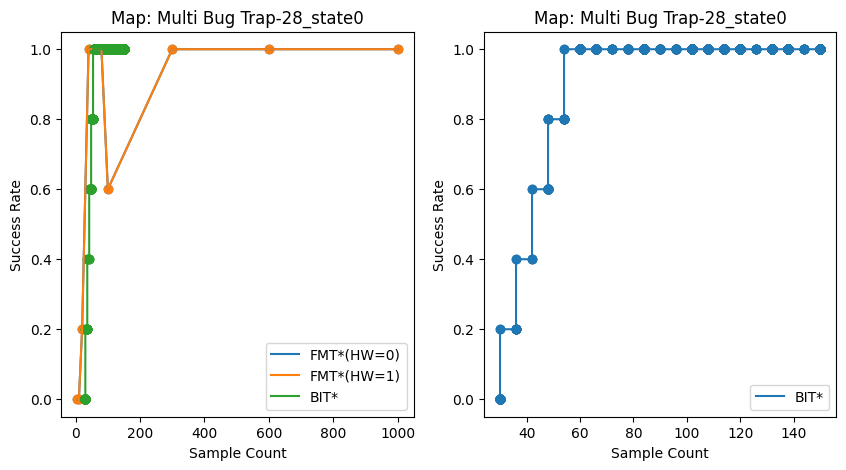

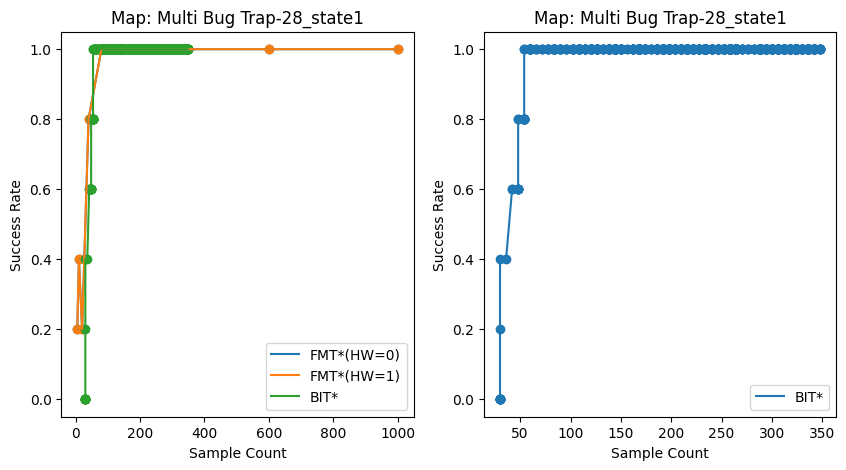

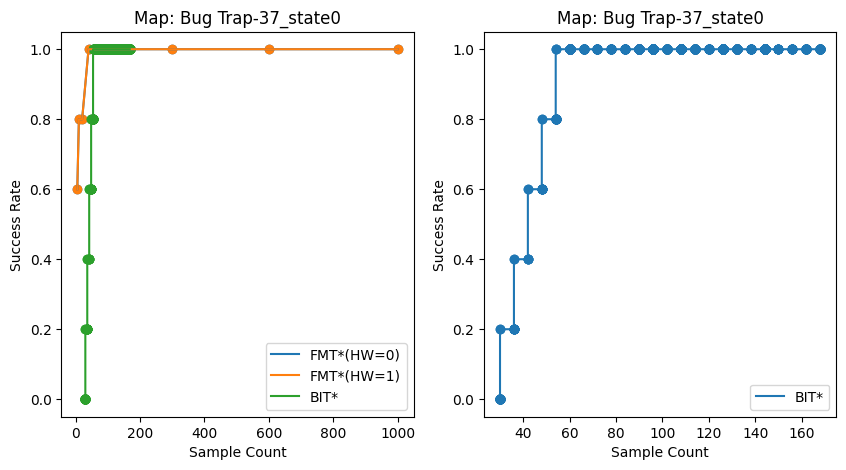

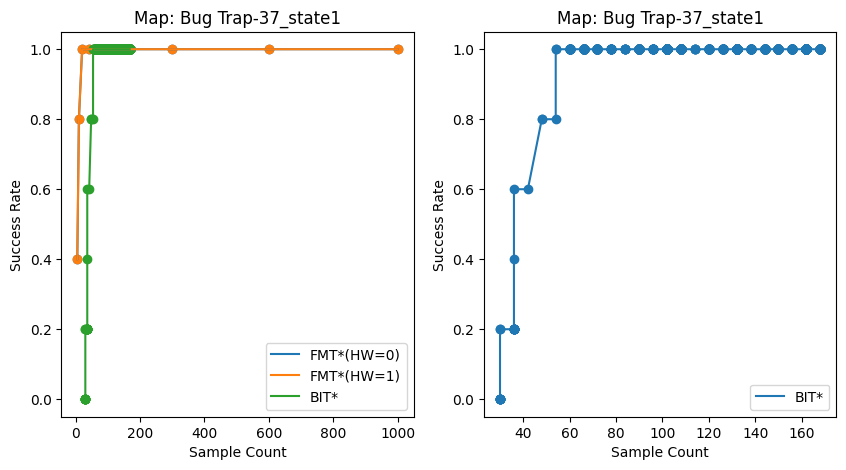

In [12]:
for idx in dlist[0]["Map Id"].unique():
    for j, sp in enumerate(dlist[0][dlist[0]["Map Id"] == idx]["Start Point"].unique()):
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].set_xlabel("Sample Count")
        ax[0].set_ylabel("Success Rate")
        ax[0].set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        ax[1].set_xlabel("Sample Count")
        ax[1].set_ylabel("Success Rate")
        ax[1].set_title(f"Map: {MAPS[idx]}-{idx}_state{j}")
        # FMT*
        for i, ddf in enumerate(dlist):
            mapi_data = ddf[(ddf["Map Id"] == idx) & (ddf["Start Point"] == sp)]
            plotdf = (mapi_data[["Any Path Found", "Batch Size"]].groupby(["Batch Size"]).sum()/cfg["runs_per_map"]).reset_index()

            ax[0].scatter(plotdf["Batch Size"], plotdf["Any Path Found"])
            ax[0].plot(plotdf["Batch Size"], plotdf["Any Path Found"], label=f"FMT*(HW={HW[i]})")
        # BIT*
        for i in range(2):
            mapi_data = bitdf[(bitdf["Map Id"] == idx) & (bitdf["Start Point"] == sp)]
            plotdf = pd.concat([
                            mapi_data[["Cumulative Num Sampled", "Iteration"]].groupby(["Iteration"]).mean(),
                            mapi_data[["Any Path Found", "Iteration"]].groupby(["Iteration"]).sum()/cfg["runs_per_map"]
                        ], axis=1)
            ax[i].scatter(plotdf["Cumulative Num Sampled"], plotdf["Any Path Found"])
            ax[i].plot(plotdf["Cumulative Num Sampled"], plotdf["Any Path Found"], label="BIT*")
            ax[i].legend()
        # Save plot
        fig.savefig(f"results/srVsc_{MAPS[idx]}-{idx}_state{j}.png", bbox_inches="tight")